In [1]:
import json
from pathlib import Path
from datetime import timedelta

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
input_data = list(Path("../data/output-infobox").rglob("*.json"))
files = [x for x in input_data if x.is_file()]
len(files) 

43

In [3]:
num_edits = 0
change_tuples = []
for file in tqdm(files[:43]):
    with open(file, 'r', encoding='utf-8') as f:
        for jsonObj in f:
            single_edit = json.loads(jsonObj)
            num_edits += 1
            #entries.append(single_edit)
            key = single_edit['key'] # is needed as there could be multiple infoboxes on the same page which could change at the same time
            title = single_edit['pageTitle']#['key']
            changes = single_edit['changes']
            timestamp = single_edit['validFrom']
            for change in changes:
                name = change['property']['name']
                current_value = change['currentValue'] if 'currentValue' in change.keys() else None
                previous_value = change['previousValue'] if 'previousValue' in change.keys() else None
                change_tuples.append((key, title, name, previous_value, current_value, timestamp))
print(num_edits) # 1934309 for 50
len(change_tuples) # 9715201 for 50

100%|██████████| 43/43 [03:30<00:00,  4.89s/it]

1571494


8087086

In [35]:
data = pd.DataFrame(change_tuples, columns=['key', 'title', 'name', 'previous_value', 'current_value', 'timestamp'])
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [15]:
data.shape[0]

8087086

Number of times the same infobox was changed at the same second

In [16]:
len(data[['key', 'title', 'name', 'timestamp']]) - len(data[['key', 'title', 'name', 'timestamp']].drop_duplicates()) 

1521

--> Can be ignored as it is so low

## Filter out creations and deletions

In [11]:
data[data['previous_value'].isna()].shape[0]

3194532

In [8]:
data[data['current_value'].isna()].shape[0]

2996504

--> About three quarters of the changes of the subset are creational or deletional changes

In [36]:
data = data.dropna(subset=['previous_value', 'current_value'])

In [15]:
data.shape[0]

1896050

## Analyze number of changes per key

In [37]:
changes_per_key = data['key'].value_counts()

In [17]:
changes_per_key

100170704-0    11821
9022080-0       6087
45647758-0      4494
133467261-0     4493
25597471-0      4208
               ...  
441686297-2        1
468323715-2        1
82060526-2         1
366096823-1        1
79873547-0         1
Name: key, Length: 9570, dtype: int64

In [18]:
frequ_of_changes = changes_per_key.value_counts()

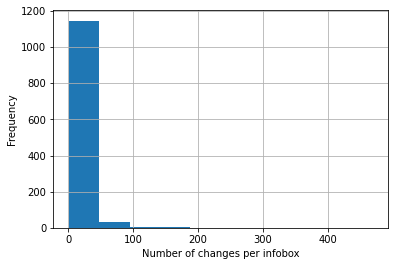

In [19]:
frequ_of_changes.hist(bins=10)
plt.xlabel("Number of changes per infobox")
plt.ylabel("Frequency")
plt.show()

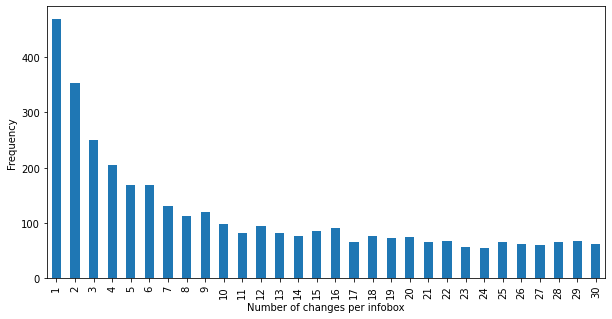

In [20]:
frequ_of_changes.sort_index(ascending=True)[:30].plot.bar(figsize=(10,5))
plt.xlabel("Number of changes per infobox")
plt.ylabel("Frequency")
plt.show()

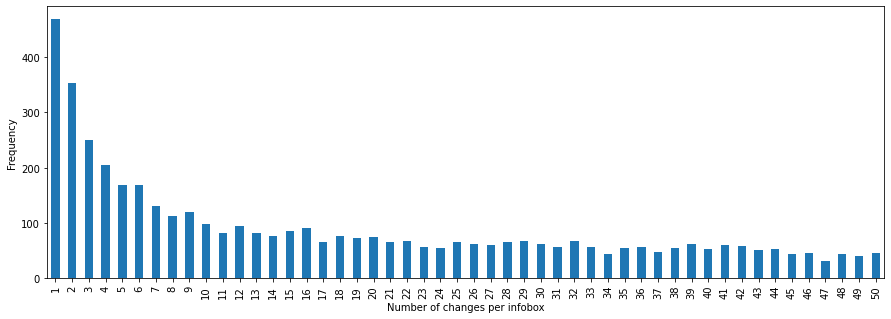

In [21]:
frequ_of_changes.sort_index(ascending=True)[:50].plot.bar(figsize=(15,5))
plt.xlabel("Number of changes per infobox")
plt.ylabel("Frequency")
plt.show()

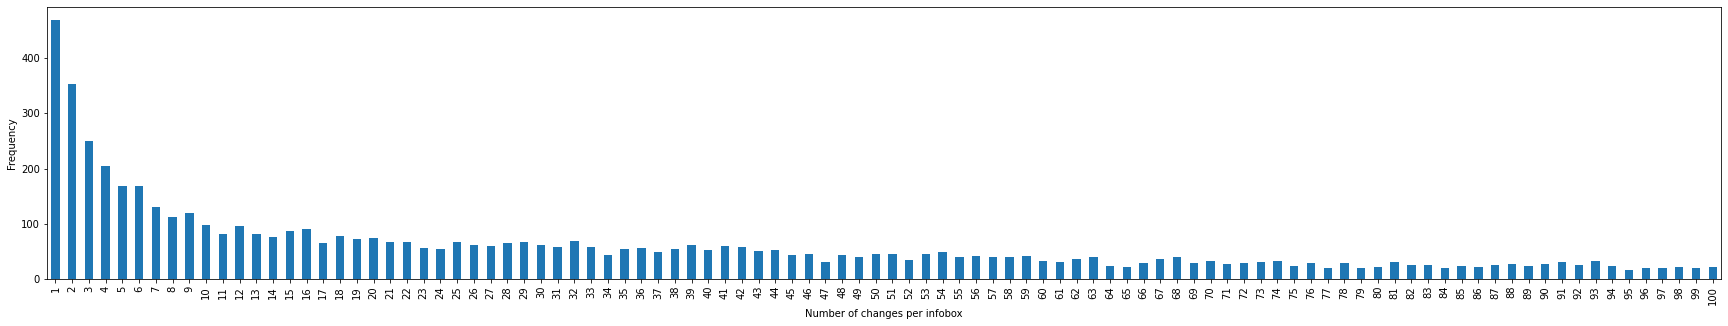

In [22]:
frequ_of_changes.sort_index(ascending=True)[:100].plot.bar(figsize=(30,5))
plt.xlabel("Number of changes per infobox")
plt.ylabel("Frequency")
plt.show()

In [23]:
frequ_of_changes.sort_index(ascending=False)[:20]

11821    1
6087     1
4494     1
4493     1
4208     1
4026     1
3858     1
3816     1
3757     1
3458     1
3419     1
3416     1
3390     1
3365     1
3346     1
3281     1
3277     1
3274     1
3167     1
3124     1
Name: key, dtype: int64

## What is a good threshold? How many changes should be our minimum to make reliable predictions?

Start with at least 100 changes

In [38]:
changes_per_key_many_changes = changes_per_key[changes_per_key>=100]

In [25]:
print('Only {} unique infoboxes left in the subset.'.format(changes_per_key_many_changes.shape[0]))

Only 3614 unique infoboxes left in the subset.


In [39]:
data = data[data['key'].isin(changes_per_key_many_changes.index)]

In [27]:
data

,key,title,name,previous_value,current_value,timestamp
364,11977384-0,Australian Democrats,ideology,[[liberalism|social liberal]],Social [[Liberalism]],2005-07-04 22:29:15+00:00
365,11977384-0,Australian Democrats,ideology,Social [[Liberalism]],[[liberalism|social liberal]],2005-07-05 00:56:54+00:00
366,11977384-0,Australian Democrats,template,infobox_political_party,infobox_australian_political_party,2005-09-23 07:26:21+00:00
368,11977384-0,Australian Democrats,party_logo,[[Image:Australiandemocratlogo.gif]],[[Image:Ausdem_newlogo.JPG|200px]],2005-10-15 06:06:44+00:00
369,11977384-0,Australian Democrats,foundation,[[1977]],1977,2005-12-17 13:54:59+00:00
...,...,...,...,...,...,...
8087081,65523991-0,Cameron Diaz,years_active,1994–2014,1990–2014,2019-07-30 15:28:45+00:00
8087082,65523991-0,Cameron Diaz,occupation,"Retired actress, writer, former model","Artist, actress, writer, former model",2019-08-11 05:22:26+00:00
8087083,65523991-0,Cameron Diaz,years_active,1990–2014,1990–2016,2019-08-25 01:25:27+00:00
8087084,65523991-0,Cameron Diaz,occupation,"Artist, actress, writer, former model",{{hlist|Artist|actress|writer|former model}},2019-08-30 02:56:02+00:00


## Look at changes per (key, propertyName) tuple

In [40]:
changes_per_key_and_name = data[['key','name']].value_counts()

In [29]:
changes_per_key_and_name

key         name              
23487584-0  genre                 1839
25883713-0  genre                 1281
24492859-0  genre                 1182
12724021-0  ideology              1144
48610185-1  genre                 1106
                                  ... 
54506549-0  crew_photo_caption       1
            crew_callsign            1
15065952-0  blank1_info_sec2         1
            blank2_name              1
32508632-0  death date               1
Length: 122697, dtype: int64

Filter out combinations with <100 changes again

In [41]:
changes_per_key_and_name_many_changes  = changes_per_key_and_name[changes_per_key_and_name>=100]

In [31]:
print('Only {} unique (infobox, property) combinations left in the subset.'.format(changes_per_key_and_name_many_changes.shape[0]))

Only 2047 unique (infobox, property) combinations left in the subset.


In [47]:
data = data[data[['key','name']].apply(tuple, axis=1).isin(changes_per_key_and_name_many_changes.index)]

In [49]:
data.shape[0]

364760